In [38]:
# default_exp data.core_pd

In [39]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [40]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [41]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [42]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [43]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [44]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)-1):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0: # if tensor has shape (bs,0) than ignore
                self.m[i] = torch.mean(o[i])
                self.s[i] = torch.std(o[i]) +self.eps
            elif type(o[i]) == TensorSeqs :
                self.m[i] = torch.mean(o[i], -1, keepdim=True)
                self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            else:
                if o[i].shape[-1]>0:
                    print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                self.m[i], self.s[i] = 0, 1
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0]         
            
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
            
        return TSMulti([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])              

    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

In [45]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)]})
df

,pred,a,b
0,"[0.7123227176010585, 0.7729592514076216, 1.0423360024179602, 1.2727892280477044, 1.252441295442369, 1.0, 0.7475587045576311, 0.7272107719522956, 0.9576639975820398, 1.2270407485923784]","[1.9589242746631386, 1.7568024953079282, 0.8588799919401328, 0.09070257317431829, 0.1585290151921035, 1.0, 1.8414709848078965, 1.9092974268256817, 1.1411200080598671, 0.2431975046920718]",0.624124
1,"[1.424645435202117, 1.5459185028152431, 2.0846720048359204, 2.545578456095409, 2.504882590884738, 2.0, 1.4951174091152621, 1.454421543904591, 1.9153279951640796, 2.454081497184757]","[2.9589242746631386, 2.7568024953079284, 1.8588799919401329, 1.0907025731743183, 1.1585290151921035, 2.0, 2.8414709848078967, 2.909297426825682, 2.1411200080598674, 1.2431975046920718]",1.370136
2,"[2.1369681528031754, 2.3188777542228647, 3.1270080072538806, 3.8183676841431136, 3.757323886327107, 3.0, 2.242676113672893, 2.1816323158568864, 2.8729919927461194, 3.6811222457771353]","[3.9589242746631386, 3.7568024953079284, 2.8588799919401326, 2.090702573174318, 2.1585290151921033, 3.0, 3.8414709848078967, 3.909297426825682, 3.1411200080598674, 2.2431975046920716]",3.047210
3,"[2.849290870404234, 3.0918370056304862, 4.169344009671841, 5.091156912190818, 5.009765181769476, 4.0, 2.9902348182305243, 2.908843087809182, 3.830655990328159, 4.908162994369514]","[4.958924274663138, 4.756802495307928, 3.8588799919401326, 3.090702573174318, 3.1585290151921033, 4.0, 4.841470984807897, 4.909297426825682, 4.141120008059867, 3.2431975046920716]",3.564024


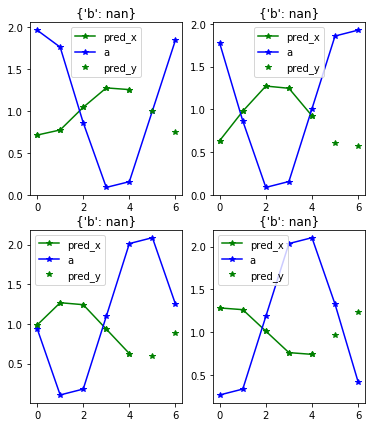

In [46]:
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        if a.shape[-1]>0:
            test_close(a.mean(),0)
            test_close(a.std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti)

dl.show_batch(max_n = 4)

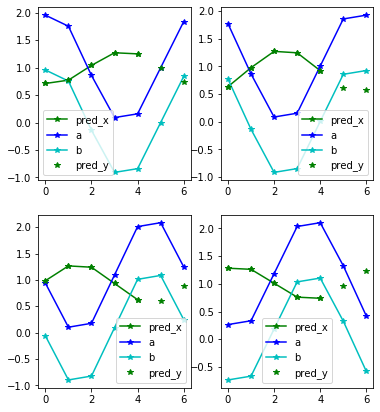

In [47]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            if a.shape[-1]>0:
                test_close(a[i].mean(),0)
                test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [48]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [49]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [50]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [51]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[-2.0439822287706515, -2.138391647883141, -1.8512157865390702, -1.8294177718861582, -1.879594031546662, -1.7037033782223008, -1.6406557907306651, -1.6914640154918112, -1.5419920351944434, -1.4062775043489322, -1.002318200758758, -0.9426654983594749, -0.6930547558278688, -0.5543387773093061, -0.3697594570688154, -0.22931284287602277, -0.07860116936245963, -0.048196795982452564, 0.08747298835001688, 0.0626571207898409, 0.0765602162056791, -0.036565361361341954, -0.13527403414063113, -0.2053177626247686, -0.034431794105949494, -0.03209594368197471, -0.3680857912191577, -0.3052602153242051, -0...","[-1.99627816245402, -1.8014998307059522, -1.5976068875689569, -1.3864903737120937, -1.171016913057318, -0.9546415593343273, -0.7409411719292436, -0.5331313412044547, -0.33363210520196607, -0.14374111009595225, 0.036541644113587624, 0.2085138036008265, 0.3745954064077711, 0.5380020428968051, 0.7023105724540608, 0.8709760488092234, 1.0468650958842565, 1.2318687543482183, 1.426647086096284, 1.6305400292332757, 1.841656543090143, 2.05713000374492, 2.273505357467907, 2.48720574487299, 2.695015575597783, 2.894514811600272, 3.084405806706286, 3.264688560915828, 3.436660720403065, 3.60274232321000...",0,0.152420
1,"[1.8037760400445717, 1.581316895360982, 1.2189810178570382, 1.1033600818172415, 1.1163191267303119, 1.1426994078853756, 1.0146847045093572, 0.996693474665729, 1.1729370272546003, 1.0675287359350336, 0.6246044341767102, 0.4663947033043913, 0.46064077506944234, -0.00016371737179929333, 0.25885272625925976, 0.2359431432952937, 0.3961024239757393, 0.3271472485705299, 0.31993545718763405, 0.4939768327119085, 0.18783613629907733, -0.15448585838735, -0.5197406379243091, -0.8808734793484112, -1.128043340351529, -1.3261169071203367, -1.495923554551423, -1.7109936748931411, -1.422429638795404, -1.51...","[1.9033374182266645, 1.7300345618288706, 1.6998649584691778, 1.8746219085576863, 2.244695355728852, 2.725379238673018, 3.1780090268823034, 3.4501573639338163, 3.4230129536384197, 3.0515003823936926, 2.3844917978022355, 1.558129629016304, 0.7631647686198422, 0.1949776342131364, 0.0002675969468337591, 0.23565863930701902, 0.8502618645351037, 1.6974703756758298, 2.5729099903330814, 3.2679774446481717, 3.6239639352539363, 3.571682312039572, 3.1458017256846325, 2.470467853957491, 1.7210681099467087, 1.0737518730329878, 0.6575668406803893, 0.5229064275757049, 0.634780681047392, 0.891816896729262...",0,0.595088
2,"[2.2189699772024007, 2.0442856224673753, 1.777923567931114, 1.6437843022562246, 1.449927297625493, 1.3500151931910154, 1.318392421028937, 1.137837226765849, 1.1003488307035578, 1.0656194770548488, 1.0884300868981482, 1.0403994133977421, 1.087356800271446, 1.0530890134590682, 1.110535346458122, 0.9177312841923045, 0.816374389694763, 0.6975251684215115, 0.5404385525027497, 0.42931601004983366, 0.2629658507910915, 0.10400162186031991, -0.02260233979212158, -0.1473371227961975, -0.17932715372554603, -0.29597366195569896, -0.2899948044536858, -0.4277555661715186, -0.43269195380425235, -0.386574...","[6.803885265265799, 6.64047496551612, 6.4490417839849945, 6.288261420648482, 6.213961786883429, 6.267955781320483, 6.468985698195212, 6.807888869294747, 7.248213844619095, 7.732301293516361, 8.191600612683489, 8.55904023946185, 8.780848690259367, 8.825433197599, 8.687693466416487, 8.388262596275432, 7.968324962406586, 7.481563025419018, 6.98521777587286, 6.5321383395555435, 6.165128102372902, 5.914074283610813, 5.7955388567220005, 5.8139302910337545, 5.963211270899346, 6.228335357083115, 6.5861211609258765, 7.005853723441258, 7.450320566256727, 7.878074790790589, 8.247416211339075, 8.52197...",0,1.576209
3,"[2.4248145186918193, 2.15578562362028, 2.020025317513335, 1.8819229939809885, 1.5992312132508626, 1.553792014529707, 1.4354546749893986, 1.232438458236568, 1.1657322954039577, 1.2127427531337718, 0.9753419790438924, 0.818867756111808, 0.704347290153826, 0.6590427669886412, 0.5363724489673872, 0.5020934314209606, 0.537135695

In [52]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [53]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [54]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [55]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [56]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [57]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [58]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [59]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [60]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head(3)

,x,weather,city,cont
0,"[[0.045339413529774476, -0.2859106796175826, -0.4531386613802183, -0.38810247232096595, -0.6024470890077134, -0.4760787945254891, -0.43732513721837374, -0.396259772223631, -0.2584119116790614, -0.17883474563451845, -0.28719404624246697, -0.14731790040971568, -0.2989587417504386, -0.0979448861008448, -0.35356425868324504, -0.3146680060799598, -0.46412054945183245, -0.4529714842400883, -0.6501031878133472, -0.6863849222158487, -0.8304066450836419, -1.2059368292592194, -1.3238572939294406, -1.6114244848818564, -1.9194105631994474, -1.8718869949594783, -2.0301943847836794, -1.8497618511851033,...","[[18.68463233147104, 18.046939916627608, 17.52633262302923, 17.23435386619105, 17.20631193072849, 17.3909869237469, 17.66678560385202, 17.87926062359987, 17.88849341160206, 17.611907002121796, 17.049501395159126, 16.283853556450833, 15.454882057385104, 14.7170342454062, 14.191903361908283, 13.930709299785999, 13.898143774423817, 13.982663370306726, 14.03033624558485, 13.892206912200836, 13.470988931862141, 12.752986136831561, 11.815466840396434, 10.806991024344603, 9.90624908879691, 9.271404811502084, 8.994818402021812, 9.076489860356043, 9.424058976943193, 9.879361974034607, 10.2637084515...",0.0,-1.258868
1,"[[2.2851821755677313, 2.1644678047747323, 2.0115101182102526, 1.797181144157045, 1.728777355765309, 1.5139278179151883, 1.4562876341000848, 1.2990178014520186, 1.179475635323342, 1.1589716332073203, 1.063641636077621, 0.9805621604094195, 0.8845518527315781, 0.7892655656036096, 0.7073074643475419, 0.7229720909173195, 0.6491980373682298, 0.6240954953474254, 0.5543213114025429, 0.43885726870992803, 0.42096849111658213, 0.3089314604932118, 0.30191327892362546, 0.18616288422451033, 0.11227736059542955, 0.08727052603284344, 0.01488749461962345, -0.02586731947947062, -0.04884019232256836, -0.1265...","[[16.961984681563788, 16.685788416828267, 16.278941647658755, 15.77888703522272, 15.23897856258062, 14.717264814737652, 14.264844292774994, 13.916505259894349, 13.685650897623285, 13.564307943279763, 13.527672788595853, 13.541541790699021, 13.570399928928381, 13.584036116569564, 13.561246879440105, 13.490240984332676, 13.366427007591573, 13.189022463427875, 12.958143996801223, 12.673674962752001, 12.336397847069062, 11.950904073408125, 11.528984874976652, 11.091843725956954, 10.669691713063393, 10.298043856956934, 10.01110380051011, 9.833675151990798, 9.773731174081103, 9.817868685253416, ...",0.0,-0.625236
2,"[[1.6601002894258816, 1.4561385636549737, 1.511375114154954, 1.3052924046995624, 1.182955700816905, 1.1830067380813172, 1.2069371633376478, 1.1214192203622753, 1.2266632433128002, 1.2770271685738384, 1.2875903668287454, 1.3864436899799686, 1.3847607604921817, 1.4361600940104107, 1.4336656056829387, 1.2854168826971528, 1.3030713744120268, 1.1372311527260017, 1.1204805990157478, 0.8444381150357162, 0.7133873137572324, 0.4452860977366483, 0.2978214738590092, 0.1171246443335599, -0.043028135619324934, -0.130190273096519, -0.3415555213142077, -0.3526847839387536, -0.45124775848643783, -0.437891...","[[9.243712360639746, 9.02282711476163, 8.781372344838989, 8.568156711815417, 8.426664155660252, 8.388636651110701, 8.469312773915927, 8.664981294266962, 8.953193423053586, 9.29561488664201, 9.643138763134433, 9.94257075698134, 10.143982219876957, 10.20773210219544, 10.110199986949318, 9.847443011980852, 9.436266894628046, 8.912548072421334, 8.327013409403225, 7.739026157878779, 7.2091957268324425, 6.791787993442858, 6.527940892884111, 6.440583016406659, 6.531725330512599, 6.782478560679983, 7.155784051140473, 7.601483161502477, 8.06303835637536, 8.485000076287632, 8.82021669713162, 9.03582...",0.0,-1.161204


Train:130; Valid: 60; Test 10


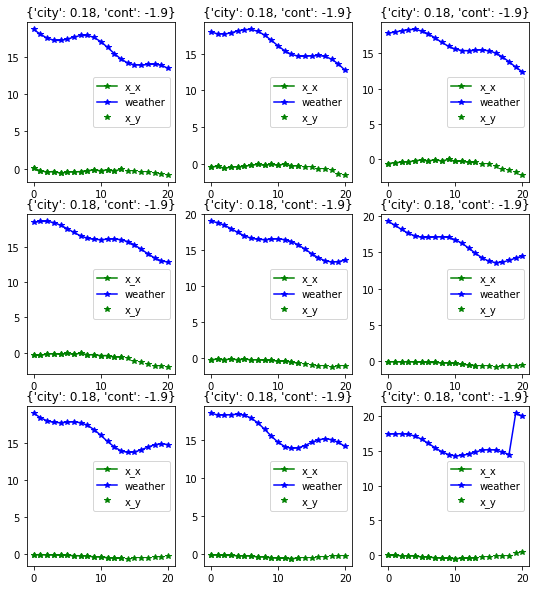

In [61]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

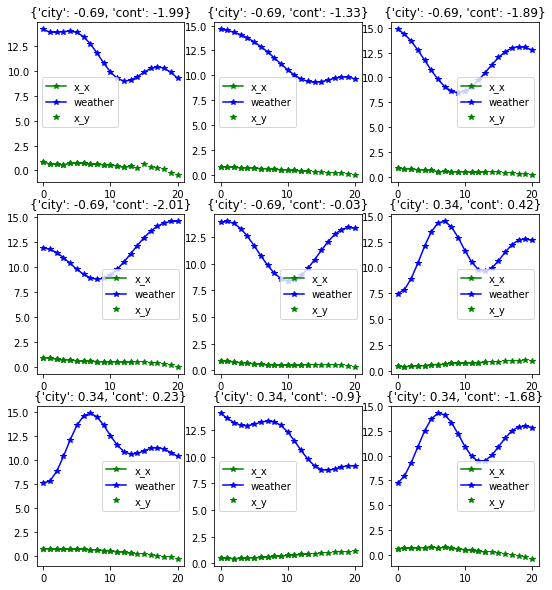

In [62]:
dbunch.test.show_batch(max_n=9)

# M5 Example

In [66]:
path = Path('../data/m5')
path.ls()

(#5) [Path('../data/m5/sales_train_validation.csv'),Path('../data/m5/sample_submission.csv'),Path('../data/m5/calendar.csv'),Path('../data/m5/m5-forecasting-accuracy.zip'),Path('../data/m5/sell_prices.csv')]

In [67]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',)
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [102]:
def _to_series(df):
    r = L()
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:]))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = _to_series(df)
    df = pd.DataFrame(data=data)
    return df
df_sales = to_contained_series(df_sales)
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 2, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 3, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 3, ...)"
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,"(0, 0, 2, 2, 0, 3, 1, 4, 1, 0, 0, 3, 4, 4, 0, 0, 1, 0, 1, 1, 7, 7, 3, 6, 3, 3, 7, 12, 4, 2, 7, 5, 12, 5, 3, 3, 7, 6, 4, 6, 3, 6, 2, 3, 4, 1, 1, 3, 2, 1, 2, 3, 4, 7, 2, 4, 4, 4, 7, 7, 2, 4, 7, 4, 4, 7, 3, 4, 2, 3, 10, 6, 8, 5, 1, 0, 2, 1, 0, 3, 0, 2, 3, 1, 1, 1, 7, 1, 4, 2, 2, 0, 0, 0, 5, 1, 1, 3, 1, 6, ...)"
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,"(0, 0, 0, 0, 0, 5, 0, 1, 1, 3, 1, 1, 0, 4, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 3, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 3, 3, 4, 4, 3, 6, 1, 0, 1, 2, 3, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 0, 3, 2, 1, 0, 0, 0, 0, 1, 1, 3, 1, 0, 1, 1, 0, 1, 2, 0, 3, 1, 2, 1, 0, 0, 0, ...)"
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,"(0, 6, 0, 2, 2, 4, 1, 8, 5, 2, 7, 5, 3, 5, 20, 8, 10, 3, 3, 4, 7, 2, 3, 5, 6, 3, 4, 1, 2, 5, 1, 2, 2, 2, 1, 9, 8, 1, 6, 3, 3, 4, 10, 4, 6, 3, 2, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 0, 1, 4, 0, 0, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 3, 1, 0, 0, 3, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, ...)"
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"


In [104]:
df_prices = pd.read_csv(path / 'sell_prices.csv')
df_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [63]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
